In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
base_dir = 'results/flow_cdf'
dirs = os.listdir(base_dir)
dirs = [d for d in dirs if d!='aus']
dirs

['NT_52',
 'SA_54',
 'WA_50',
 'NSW_56',
 'QLD_55',
 'VIC_54',
 'WA_52',
 'NSW_55',
 'ACT_55',
 'TAS_55',
 'NT_53',
 'QLD_54',
 'WA_51',
 'QLD_56',
 'VIC_55',
 'SA_53']

In [3]:
res_df_list = [pd.read_csv(os.path.join(base_dir, d, 'results.csv')).drop(columns=['Unnamed: 0']) for d in dirs]
res_df = pd.concat(res_df_list)
res_df.station_id = res_df.station_id.apply(lambda x: x[2:-1])
res_df = res_df.set_index('station_id', drop=True)

In [4]:
res_df.mean()

train_mse    0.026201
test_mse     0.043788
dtype: float64

<AxesSubplot:ylabel='Frequency'>

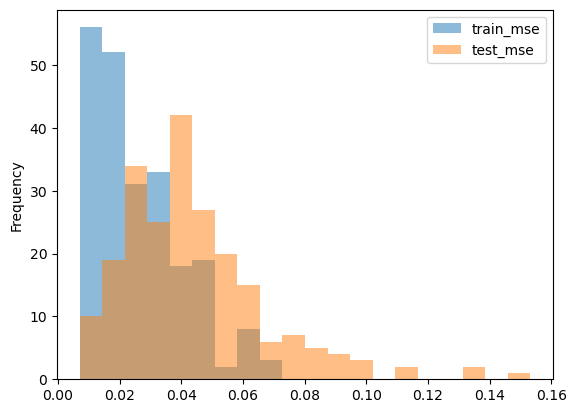

In [5]:
res_df.plot.hist(bins=20, alpha=0.5)

In [6]:
from data.tf.camels_dataset import CamelsDataset

2024-09-10 15:39:22.601970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 15:39:22.911148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 15:39:22.917639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 15:39:23.004071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 15:39:45.509161: W tensorflow/comp

In [7]:
camels_dir = '../data/camels/aus'
camels_ds = CamelsDataset(data_dir=camels_dir)

In [8]:
res_df.head()

,train_mse,test_mse
station_id,,
G8110004,0.030313,0.076939
G8110016,0.030466,0.038812
G8140040,0.020318,0.038431
G8140161,0.025811,0.049235
G8150018,0.016000,0.029105


In [9]:
loc_df = camels_ds.repo.data[['lat_outlet', 'long_outlet']].to_dataframe()
loc_df.head()

,lat_outlet,long_outlet
station_id,,
912101A,-18.643611,139.253056
912105A,-18.970833,138.803333
915011A,-20.177500,144.524444
917107A,-18.133611,144.306667
919003A,-16.471389,144.290556


In [10]:
station_df = pd.concat([res_df, loc_df], axis=1)
station_df.head()

,train_mse,test_mse,lat_outlet,long_outlet
station_id,,,,
G8110004,0.030313,0.076939,-15.766944,130.033611
G8110016,0.030466,0.038812,-17.448611,130.839444
G8140040,0.020318,0.038431,-13.830800,130.735800
G8140161,0.025811,0.049235,-13.737778,131.102778
G8150018,0.016000,0.029105,-12.605556,131.073611


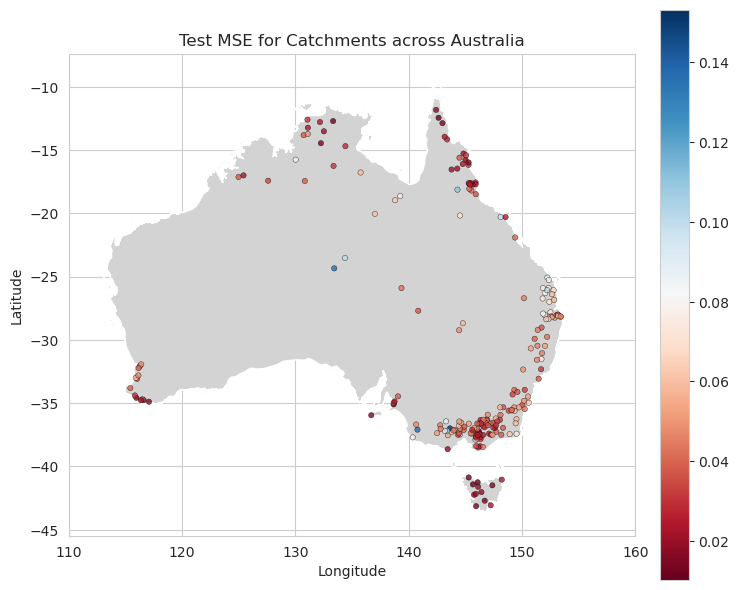

In [15]:
# Load the shapefile of Australia
australia = gpd.read_file('../data/camels/aus/shp/AUS_2021_AUST_GDA2020.shp')

# Define the CRS of the shapefile manually
australia.crs = 'epsg:7844'

# Create a GeoDataFrame from the DataFrame of cities
gdf_cities = gpd.GeoDataFrame(station_df, geometry=gpd.points_from_xy(station_df.long_outlet, station_df.lat_outlet))

# Set the CRS of the GeoDataFrame to EPSG 7844
# https://epsg.io/7844
gdf_cities.crs = 'epsg:7844'

# Reproject the GeoDataFrame of cities to match the CRS of the shapefile
gdf_cities = gdf_cities.to_crs(australia.crs)

# Perform a spatial join to link the cities to their corresponding polygons in the shapefile
gdf_cities = gpd.sjoin(gdf_cities, australia, predicate='within')

# Set up the plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 8))

# Define a custom dark color palette
# custom_palette = sns.color_palette(['darkblue', 'black', 'purple','darkred', 'darkgreen', 'darkorange', 'brown' , 'blue'], n_colors=len(df['state_num'].unique()))

# # Plot the cities colored by priority with adjustments
sns.scatterplot(ax=ax, data=gdf_cities, x='long_outlet', y='lat_outlet', hue='test_mse', palette='RdBu', s=15, edgecolor='black', alpha=0.8, legend=False, zorder=2)

norm = plt.Normalize(gdf_cities['test_mse'].min(), gdf_cities['test_mse'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Add a colorbar
ax.figure.colorbar(sm,fraction=0.046, pad=0.04)


# Set x-axis limits
ax.set_xlim(110, 160)

# Add the shapefile of Australia as a background map
australia.plot(ax=ax, color='lightgrey', edgecolor='white', zorder=1)

# Set the plot title and axis labels
plt.title('Test MSE for Catchments across Australia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()